In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from scipy.interpolate import interp1d
import scipy.optimize as opt
import os
# import importlib
# import seaborn as sns

user_path = '/Users/oliviapereira/Desktop' if (os.path.isdir('/Users/oliviapereira')) else '/Users/audrey/Documents/PHYS469'

### Load Data

In [23]:
file_list = user_path + '/PHYS469/saturation_spectroscopy/interim_data_list.txt'
oct10_raw_data = {}

with open(file_list, 'r') as file_names:
    # Go through good data files
    for file_path in file_names:
        file_path = file_path.strip()
        # Read the lines of the file
        with open(user_path+file_path, 'r') as f:
            lines = f.readlines()
        # Find end of the header (the line that starts with 'x ys')
        for i, line in enumerate(lines):
            if line.startswith('x	y'):
                lines_to_skip = i
                break

        # Read data (skip header)
        data = np.genfromtxt(user_path+file_path, skip_header=lines_to_skip, names=True, missing_values='_', filling_values=0)
        reshaped_data = np.vstack([data[field] for field in data.dtype.names]).T
        # reshaped_data[reshaped_data == 0] = 0.000001

        # Add to a dict
        file_dict = {label: reshaped_data[:,i] for i,label in enumerate(data.dtype.names)}
        oct10_raw_data[file_path[53:57]] = file_dict

### Plot Data

In [24]:
data_time = oct10_raw_data['run3']['x']
data_voltage = -oct10_raw_data['run3']['y3']

In [25]:
def gaussian(x, a, b, c, d):
    return a * np.exp(-(x - b)**2 / (2 * c**2)) + d

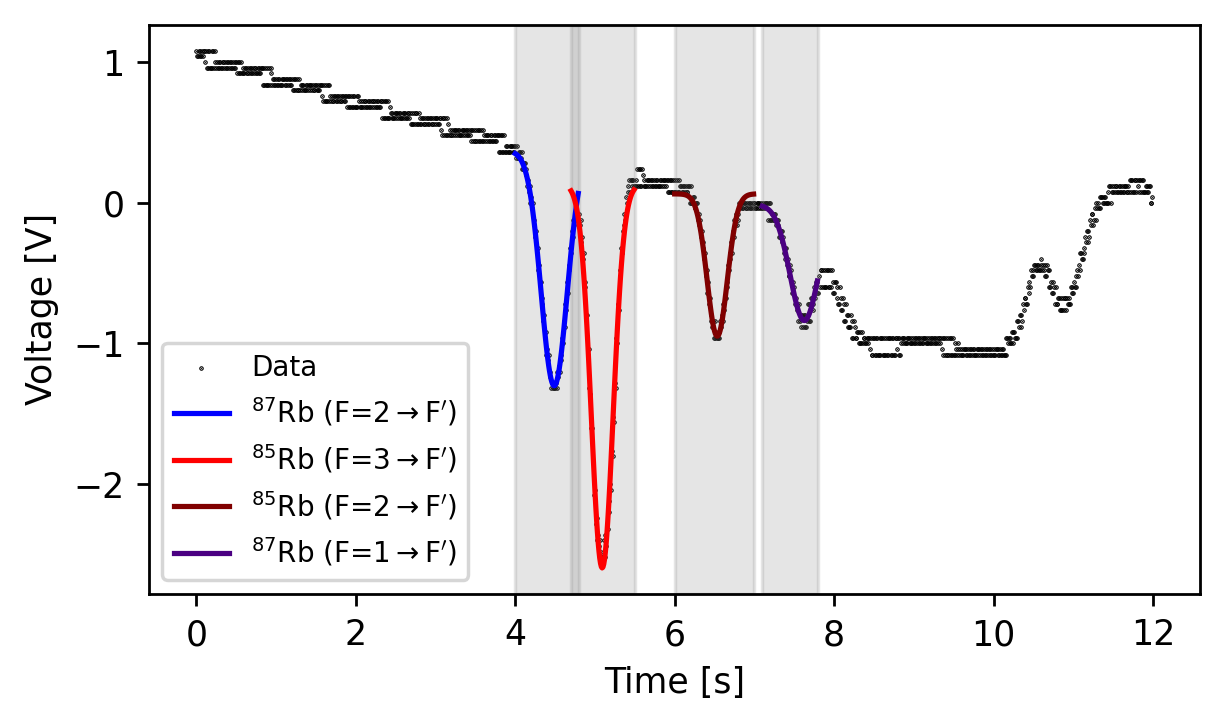

In [26]:
time_multiplier = 1000

# Get info for each dip
colors = ['blue', 'red', 'maroon', 'indigo']
fit_labels = [r'$^{87}$Rb (F=2$\to$F$^{\prime}$)', r'$^{85}$Rb (F=3$\to$F$^{\prime}$)', r'$^{85}$Rb (F=2$\to$F$^{\prime}$)', r'$^{87}$Rb (F=1$\to$F$^{\prime}$)']
# fit_info = [[87,2],[85,3],[85,2],[87,1]]
# Data slice
slice_edges = np.array([0.004, 0.0048, 0.0047, 0.0055, 0.006, 0.007, 0.0071, 0.0078])
slice_indices = [np.argmin(np.abs(edge - data_time)) for edge in slice_edges]

# Figure
plt.figure(figsize=(5,3), dpi=250)

# Plot data
plt.scatter(data_time*time_multiplier, data_voltage, color='k', s=0.1, label = 'Data')

# to vizualize the slices (we dont have to keep this, it was mostly for myself hehe)
for start,stop in zip(slice_edges[:-1:2], slice_edges[1::2]):
    plt.axvspan(start*time_multiplier, stop*time_multiplier, color='gray', alpha=0.2)

# Fit the data
fit_dict = {}
for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2])):
    popt, pcov = opt.curve_fit(gaussian, data_time[start:stop], data_voltage[start:stop], 
                               p0=[-1, data_time[int((stop - start) / 2) + start], 0.0002, -1])
    # Add to dictionary
    fit_dict[f'popt_{i}'] = popt
    fit_dict[f'err_{i}'] = np.sqrt(np.diag(pcov))
    # Plot the fit
    fit_voltage = gaussian(data_time[start:stop], *popt)
    plt.plot(data_time[start:stop]*time_multiplier, fit_voltage, label=fit_labels[i], color=colors[i])
    # put params in plot legend instead?

# Labels
plt.xlabel('Time [s]')
plt.ylabel('Voltage [V]')
plt.legend(fontsize=8)

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/voltage-time.png')
plt.show()

In [27]:
fit_dict

{'popt_0': array([-1.66914087e+00,  4.48863580e-03,  1.62961345e-04,  3.68100361e-01]),
 'err_0': array([1.96426486e-02, 1.42294249e-06, 2.59200832e-06, 1.86890409e-02]),
 'popt_1': array([-2.72489484e+00,  5.09088259e-03, -1.36104550e-04,  1.28923862e-01]),
 'err_1': array([4.10361968e-02, 1.75343029e-06, 3.01822358e-06, 3.69583542e-02]),
 'popt_2': array([-1.01166944e+00,  6.53388732e-03,  1.26516589e-04,  6.31387287e-02]),
 'err_2': array([1.53857938e-02, 2.00427937e-06, 2.59412790e-06, 9.35169954e-03]),
 'popt_3': array([-8.23707043e-01,  7.62658494e-03,  1.78654591e-04, -1.35672374e-02]),
 'err_3': array([1.75879743e-02, 3.94230998e-06, 6.40648210e-06, 1.71323234e-02])}

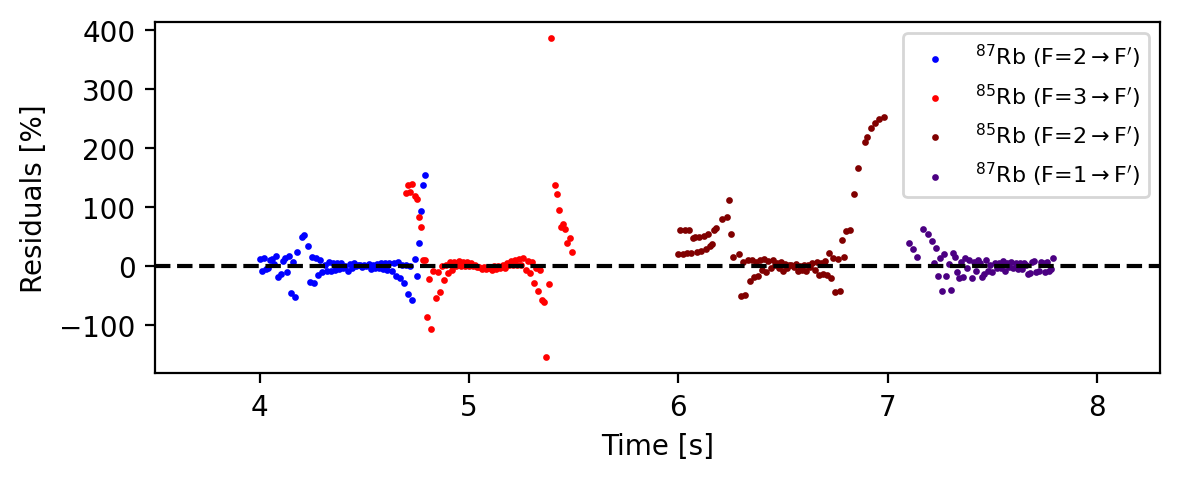

In [28]:
plt.figure(figsize=(6,2.5), dpi=200)

# Plot residuals for the fits
for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2])):
    # Get data
    data = data_voltage[start:stop]
    time = data_time[start:stop]
    # Get fit voltage
    fit_voltage = gaussian(time, *fit_dict[f'popt_{i}'])
    # Get indices where the data isnt 0
    nonzero_indices = np.where(data != 0)
    # Calculate % residuals
    residuals = (data[nonzero_indices] - fit_voltage[nonzero_indices]) / data[nonzero_indices] * 100
    plt.scatter(time[nonzero_indices]*time_multiplier, residuals, label=fit_labels[i], s=2, color=colors[i])

# x axis, in seconds
start_time = data_time[slice_indices[0]]*time_multiplier
stop_time = data_time[slice_indices[-1]]*time_multiplier
plt.xlim(start_time - 0.5, stop_time + 0.5)
plt.hlines(0, start_time - 0.5, stop_time + 0.5, color='k', linestyle='--')

# Labels
plt.xlabel('Time [s]')
plt.ylabel('Residuals [%]')
# plt.ylim(-50,50)
plt.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/residuals.png')
plt.show()

In [29]:
# getting FWHM of all fits
fwhm = [2*np.sqrt(2*np.log(2))*fit_dict[f'popt_{i}'][2] for i in range(int(len(fit_dict)/2))]
fwhm_err = [2*np.sqrt(2*np.log(2))*fit_dict[f'err_{i}'][2] for i in range(int(len(fit_dict)/2))]
print(fwhm)

[np.float64(0.0003837446410558674), np.float64(-0.0003205017215059242), np.float64(0.000297923800712964), np.float64(0.0004206994112196033)]


In [30]:
# chi square of fits
chi_square = [np.sum((data_voltage[start:stop] - gaussian(data_time[start:stop], *fit_dict[f'popt_{i}']))**2 / gaussian(data_time[start:stop], *fit_dict[f'popt_{i}'])) 
              for i,(start,stop) in enumerate(zip(slice_indices[:-1:2], slice_indices[1::2]))]
print(chi_square)

[np.float64(-0.8429848730683173), np.float64(8.910869694569904), np.float64(2.458966579505602), np.float64(-0.7830702427317925)]


### FWHM

#### Theoretical

In [31]:
# Constants
k_B = 1.380649e-23  # Boltzmann constant in J/K
T_Celsius = 45.6  # Temperature in Celsius
T_Kelvin = T_Celsius + 273.15  # Convert to Kelvin
mass_85Rb = 1.409993199e-25  # Mass of 85Rb in kg
mass_87Rb = 1.44316060e-25   # Mass of 87Rb in kg

# Convert Celsius to Kelvin
T = T_Kelvin

# Doppler broadening FWHM formula for velocity
def doppler_fwhm(T, mass):
    return np.sqrt(8 * k_B * T * np.log(2) / mass)

# Calculate FWHM for each isotope, and multiply by the central frequency of the laser
fwhm_85Rb = doppler_fwhm(T, mass_85Rb) 
fwhm_87Rb = doppler_fwhm(T, mass_87Rb) 

print(f'FWHM for 85Rb: {fwhm_85Rb} s')
print(f'FWHM for 87Rb: {fwhm_87Rb} s')

FWHM for 85Rb: 0.00032449690269018765 s
FWHM for 87Rb: 0.0003207463574125443 s


#### Data

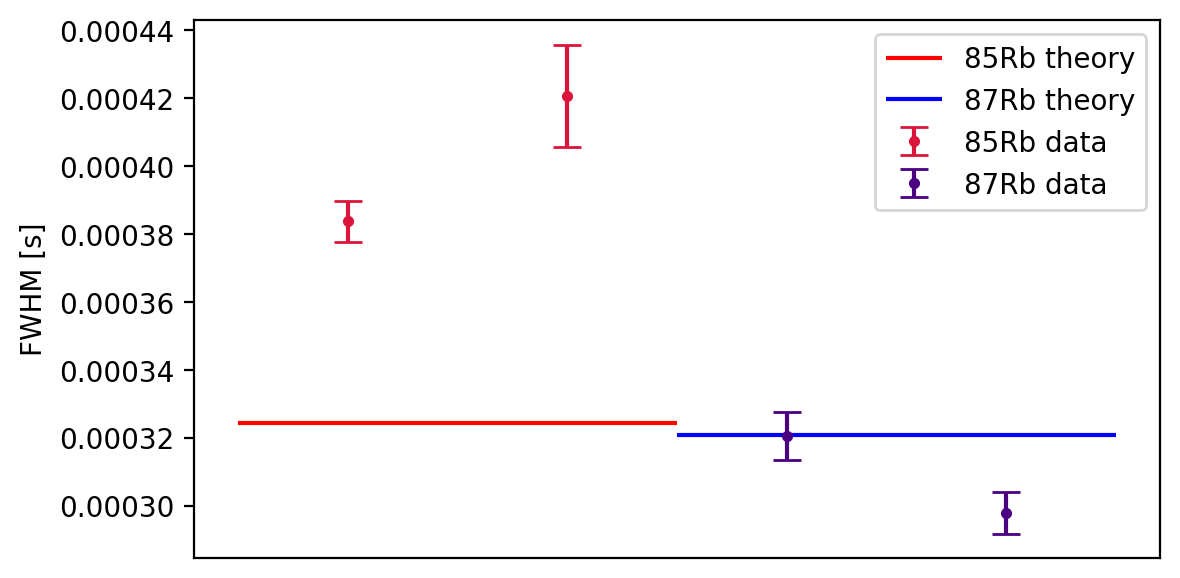

In [32]:
# plot the FWHM
plt.figure(figsize=(6, 3), dpi=200)
# plt.scatter(np.arange(len(fwhm)), np.abs(fwhm), label = 'Data')

plt.errorbar([0.25, 0.75], [fwhm[0], fwhm[3]], yerr = [fwhm_err[0], fwhm_err[3]],  color = 'crimson', label = '85Rb data', fmt = '.', capsize=5)
plt.errorbar([1.25, 1.75], [np.abs(fwhm[1]), fwhm[2]], yerr = [fwhm_err[1], fwhm_err[2]], color = 'indigo', label = '87Rb data', fmt = '.', capsize = 5)

plt.hlines(fwhm_85Rb, 0, 1, color='r', label = '85Rb theory')
plt.hlines(fwhm_87Rb, 1, 2, color='b', label = '87Rb theory')

plt.xticks([])
plt.ylabel('FWHM [s]')
plt.legend(loc = 'upper right')

plt.tight_layout()
plt.savefig(user_path + '/PHYS469/saturation_spectroscopy/figures/fwhm_fits.png')
plt.show()